In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Defining spacial and time domain and increments in these domains

In [4]:
# NOTE: All dimensions are in metres and times in seconds

# Time duration of simulation
simulation_duration = 3600  # one hour (in seconds)

# Dimensions of oven
radius_oven = 0.2
height_oven = 0.1

# Increments
base_time_increment = 0.25
base_radial_increment = 0.005
base_height_increment = 0.005

# Defining physical constants

In [5]:
# NOTE: All dimensions are in metres and times in seconds

# Dimensions of pizza
radius_crust = 0.15
radius_tomato_paste = 0.13

height_dough = 0.01
height_tomato_paste = 0.004

# Dimensions of cake
radius_cake = 0.15
height_cake = 0.15

# Initial temperatures
temperature_oven_initial = 25
temperature_dough_initial = 30
temperature_tomato_paste_initial = 10
temperature_cake_initial = 15

# Constants for dirchlet boundary conditions
temperature_oven_base_centre = 200
temperature_oven_base_outer = 100

# Constants for von-neumann boundary conditions
convective_heat_transfer_coefficient = 500
thermal_conductivity_air = 25
temperature_infinity = 25

# Thermal diffusivities
diffusivity_air = 1.9e-5
diffusivity_crust = 1.28e-7
diffusivity_tomato_paste = 1.737e-7
diffusivity_cake = 1.09e-7

# Creating dependent variable arrays

In [6]:
def get_dependent_variable_arrays(simulation_duration, time_increment, radial_increment, height_increment):

    time_array = np.arange(0, simulation_duration + time_increment, time_increment)
    radius_array = np.arange(0, radius_oven + radial_increment, radial_increment)
    height_array = np.arange(0, height_oven + height_increment, height_increment)
    
    return time_array, radius_array, height_array


In [7]:
def get_number_of_increments_in_dependent_variable_arrays(time_array, radius_array, height_array):

    number_of_increments_in_time_array = len(time_array)
    number_of_increments_in_radius_array = len(radius_array)
    number_of_increments_in_height_array = len(height_array)

    return number_of_increments_in_time_array, number_of_increments_in_radius_array, number_of_increments_in_height_array

# Initializing diffusivity and temperature matrices 

In [8]:
def set_initial_Temperature_and_Diffusivity_matrices(number_time_increments, number_radius_increments, number_height_increments):

    Diffusivity_matrix_initial = np.ndarray(shape=(number_radius_increments, number_height_increments))
    Diffusivity_matrix_initial[:, :] = diffusivity_air

    Temperature_matrix_initial = np.ndarray(shape=(number_time_increments, number_radius_increments, number_height_increments))

    return Temperature_matrix_initial, Diffusivity_matrix_initial

# Boundary Conditions
### Linear Functions for temperature of oven base and wall (dirchlet boundary condition) 

In [9]:
def temperature_oven_base(radius):
    return temperature_oven_base_centre - (temperature_oven_base_centre - temperature_oven_base_outer) * radius / radius_oven


def temperature_oven_wall(height):
    return temperature_oven_base_outer - (temperature_oven_base_outer - temperature_infinity) * height / height_oven

### Setting initial conditions & dirchlet boundary conditions and changing diffisivity matrix

In [10]:
def set_IC_BCs(Temperature_matrix, Diffusivity_matrix, pizza_is_in_oven_bool, cake_is_in_oven_bool, radius_array, height_array, 
    number_radius_increments, number_height_increments):

    Temperature_matrix[0, :, :] = temperature_oven_initial # setting Temperature everywhere to be the initial oven temperature at time = 0

    for i in range(number_radius_increments):
        for j in range(number_height_increments):
            Temperature_matrix[:, i, 0] = temperature_oven_base(radius_array[i])
            Temperature_matrix[:, -1, j] = temperature_oven_wall(height_array[j])

            if pizza_is_in_oven_bool == True: # If we are modelling the temperature distribution with a PIZZA in the oven

                if 0 <= radius_array[i] <= radius_crust and 0 <= height_array[j] <= height_dough: # current position is within dough
                    Diffusivity_matrix[i, j] = diffusivity_crust # resetting diffusivity at i, j to that of the pizza crust
                    Temperature_matrix[0, i, j] = temperature_dough_initial

                if 0 <= radius_array[i] <= radius_tomato_paste and height_dough < height_array[j] <= height_dough + height_tomato_paste: # current pos in paste
                    Diffusivity_matrix[i, j] = diffusivity_tomato_paste
                    Temperature_matrix[0, i, j] = temperature_tomato_paste_initial

            if cake_is_in_oven_bool == True: # # If we are modelling the temperature distribution with a CAKE in the oven
                if 0 <= radius_array[i] <= radius_cake and 0 <= height_array[j] <= height_cake:
                    Diffusivity_matrix[i, j] = diffusivity_cake
                    Temperature_matrix[0, i, j] = temperature_cake_initial

    return Temperature_matrix, Diffusivity_matrix

# Performing time marching simulation
# using discretised PDE and robin boundary condition

In [11]:
def perform_simulation(Temperature_matrix, Diffusivity_matrix, radius_array, number_time_increments, number_radius_increments, number_height_increments):
    for p in range(1, number_time_increments): # time index, p
        for i in range(number_radius_increments - 2, 0, -1): # radius index, i
            for j in range(1, number_height_increments - 1): # height index, j
                diffusivity = Diffusivity_matrix[i, j]

                # Defining constants for use below
                Cr1 = diffusivity * dt / (2 * dr)
                Cr2 = diffusivity * dt / dr ** 2
                Cz2 = diffusivity * dt / dz ** 2

                # Setting temperature at current dependent variable indexes using discretised PDE:
                Temperature_matrix[p, i, j] = Temperature_matrix[p-1, i-1, j] * (Cr2 - Cr1 * 1 / radius_array[i]) + \
                    Temperature_matrix[p-1, i+1, j] * (Cr2 + Cr1 * 1 / radius_array[i]) + \
                    Temperature_matrix[p-1, i, j] * (1 - 2 * Cr2 - 2 * Cz2) + \
                    Temperature_matrix[p-1, i, j-1] * Cz2 + \
                    Temperature_matrix[p-1, i, j+1] * Cz2

                # dT/dr = 0 at radius = 0 (i = 0):
                Temperature_matrix[p, 0, j] = Temperature_matrix[p, 1, j]

            # Robin boundary condition at height = height_oven (j = -1)
            Temperature_matrix[p, i, -1] = ((thermal_conductivity_air * Temperature_matrix[p, i, -2]) / dz - convective_heat_transfer_coefficient *
                                            temperature_infinity) / (thermal_conductivity_air / dz + convective_heat_transfer_coefficient)

        # Robin B.C. for i = 0 (as this index is missed in above for loop)
        Temperature_matrix[p, 0, -1] = ((thermal_conductivity_air * Temperature_matrix[p, 0, -2]) / dz + convective_heat_transfer_coefficient *
                                        temperature_infinity) / (thermal_conductivity_air / dz + convective_heat_transfer_coefficient)

    return Temperature_matrix

# Plotting Functions

## Function for plotting the minimum or average temperature against time for multiple 2D temperature matrices

In [12]:
def plot_temperature_against_time(option, Temperature_matrices, time_array, number_time_increments):
    
    fig, axs = plt.subplots(1, figsize=(15,8))

    matrix_names = ['oven with pizza', 'oven with nothing', 'oven with cake']

    for i in range(len(Temperature_matrices)):
        temperatures = []
        if option == 'Average': # for plotting average temperature against time
            for p in range(number_time_increments): # p is time index
                temperatures.append(np.average(Temperature_matrices[i][p, :, :]))

        if option == 'Minimum': # for plotting minimum temperature against time
            for p in range(number_time_increments):
                temperatures.append(np.min(Temperature_matrices[i][p, :, :]))

        axs.plot(time_array, temperatures, label=f'{option} Temperature for {matrix_names[i]}')
    
    axs.legend()

    plt.rcParams['legend.title_fontsize'] = 'large'

    axs.set_title(f'{option} Temperature against time', fontsize=20)
    axs.set_ylabel('Temperature ($^o$C)', fontsize = 16)
    axs.set_xlabel('Time (s)', fontsize = 16)

    plt.show()

# Filled Contour plots

In [13]:
def plot_contours(Temperature_matrix, number_of_plots, radius_array, height_array):
    (Zg, Rg) = np.meshgrid(height_array, radius_array)

    if number_of_plots == 3:
        fig, axs = plt.subplots(1,3, figsize=(20,8))

    if number_of_plots == 15:
        fig, axs = plt.subplots(5,3, figsize=(20,20))
    
    row = 1
    col = 1

    if number_of_plots == 3:
        times_of_interest = [0, 500, 10000]

    
    if number_of_plots == 15:
        times_of_interest = [i for i in range(0, 11, 2)] + [50, 100, 500, 1000, 5000, 8000, 10000, 12000, 14000]
    
    for time in times_of_interest:

        if number_of_plots == 3:
            axs_index = col - 1
        if number_of_plots == 15:
            axs_index = (row - 1, col - 1)
        
        im = axs[axs_index].contourf(Rg, Zg, Temperature_matrix[time, :, :])
        axs[axs_index].set_ylabel('Height (m)', fontsize  = 16)
        axs[axs_index].set_xlabel('Radius (m)', fontsize = 16)

        x_labels = np.arange(0, 0.2+0.05, 0.05)
        axs[axs_index].set_xticks(x_labels)
        axs[axs_index].set_title(f'{time} seconds', fontsize = 20)

        divider = make_axes_locatable(axs[axs_index])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Temperature ($^o$C)', rotation=270, fontsize = 16)
        cbar.ax.get_yaxis().labelpad = 15

        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
        
        
        if col % 3 == 0:
            row += 1
            col = 1
        else:
            col += 1

    plt.show()

In [14]:
def perform_simulation_and_plot_contours(time_increment, radial_increment, height_increment, number_of_plots, pizza_is_in_oven_bool, cake_is_in_oven_bool):
    t_array, r_array, z_array = get_dependent_variable_arrays(simulation_duration, time_increment, radial_increment, height_increment)
    Nt, Nr, Nz = get_number_of_increments_in_dependent_variable_arrays(t_array, r_array, z_array)
    Temperature_matrix_initial, Diffusivity_matrix_initial = set_initial_Temperature_and_Diffusivity_matrices(Nt, Nr, Nz)
    
    Temperature_matrix, Diffusivity_matrix = set_IC_BCs(
        Temperature_matrix=Temperature_matrix_initial, 
        Diffusivity_matrix=Diffusivity_matrix_initial, 
        pizza_is_in_oven_bool=pizza_is_in_oven_bool,
        cake_is_in_oven_bool=cake_is_in_oven_bool,
        radius_array=r_array,
        height_array=z_array,
        number_radius_increments=Nr,
        number_height_increments=Nz)

    Temperature_matrix = perform_simulation(
        Temperature_matrix=Temperature_matrix, 
        Diffusivity_matrix=Diffusivity_matrix,
        radius_array=r_array,
        number_time_increments=Nt,
        number_radius_increments=Nr,
        number_height_increments=Nz)

    plot_contours(Temperature_matrix = Temperature_matrix, 
        number_of_plots = number_of_plots,
        radius_array = r_array,
        height_array = z_array)

    return Temperature_matrix

# Simulation with pizza in oven

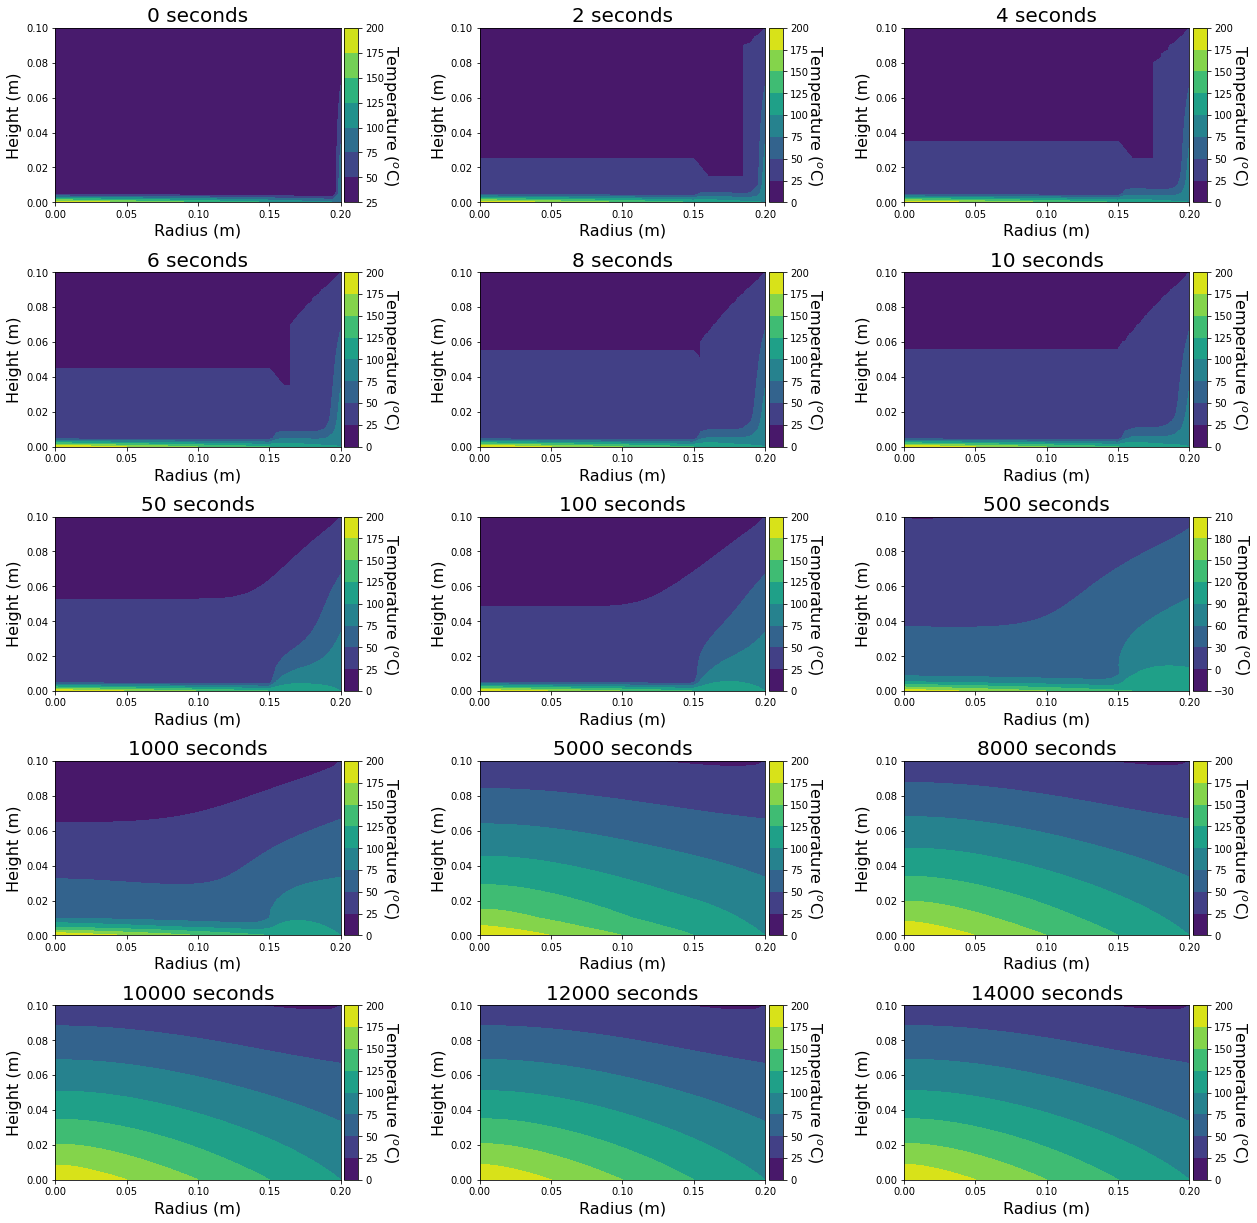

In [15]:
dt = base_time_increment
dr = base_radial_increment
dz = base_height_increment

Temperature_with_pizza_matrix = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=15, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)

# Simulation with no pizza in oven

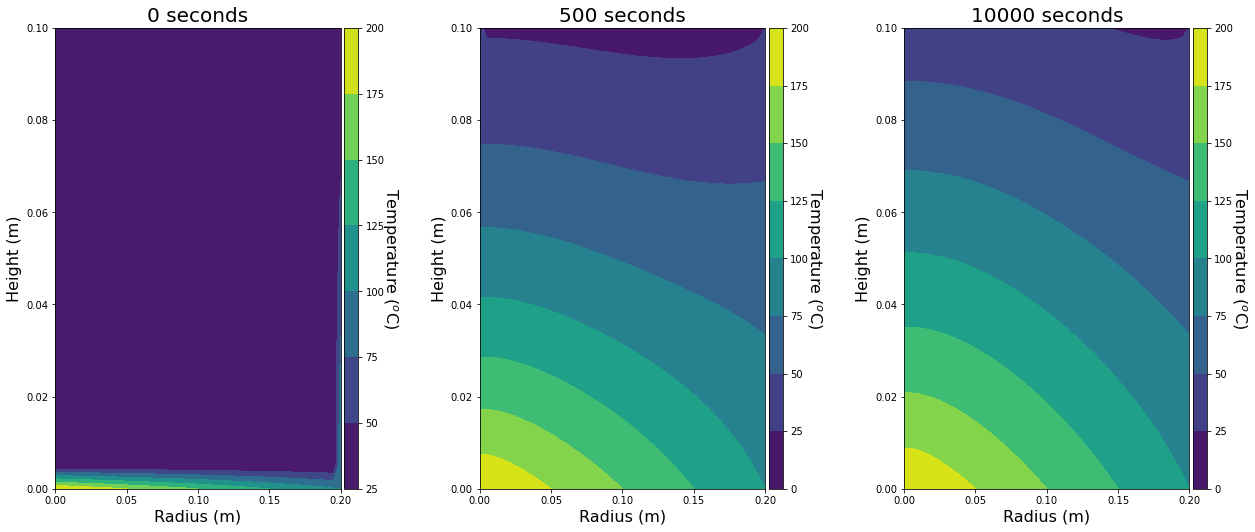

In [16]:
dt = base_time_increment
dr = base_radial_increment
dz = base_height_increment

Temperature_with_nothing_in_oven_matrix = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=3, 
    pizza_is_in_oven_bool=False, 
    cake_is_in_oven_bool=False
)

### Comparing the above distributions with the original 'pizza in oven' distributions:

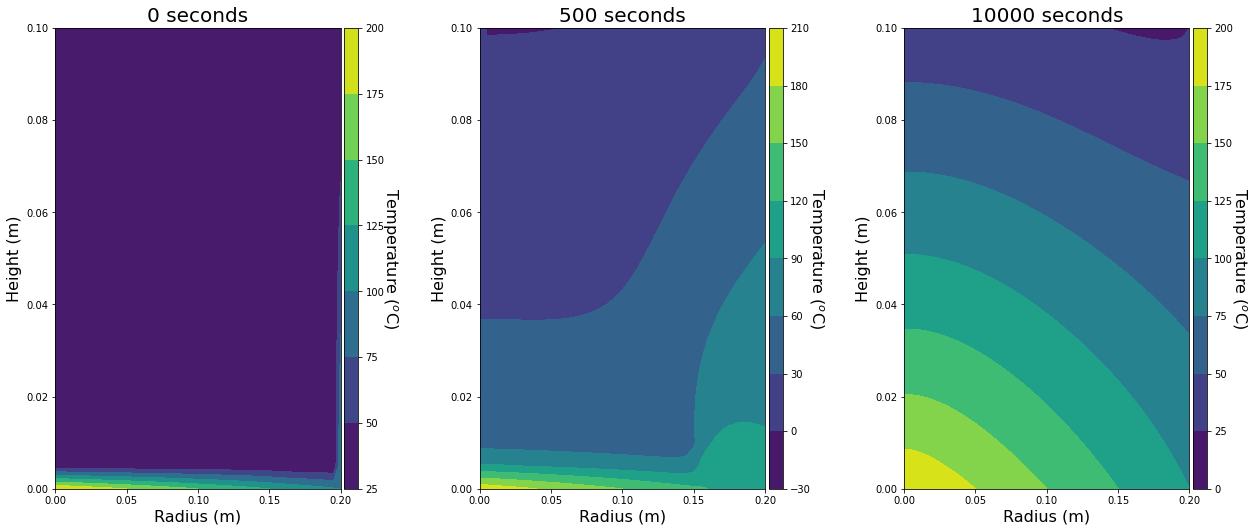

In [17]:
t_array, r_array, z_array = get_dependent_variable_arrays(simulation_duration=simulation_duration, time_increment=dt, 
radial_increment=dr, height_increment=dz)
plot_contours(Temperature_matrix=Temperature_with_pizza_matrix, number_of_plots=3, radius_array=r_array, height_array=z_array)

# Simulation with cake in the oven

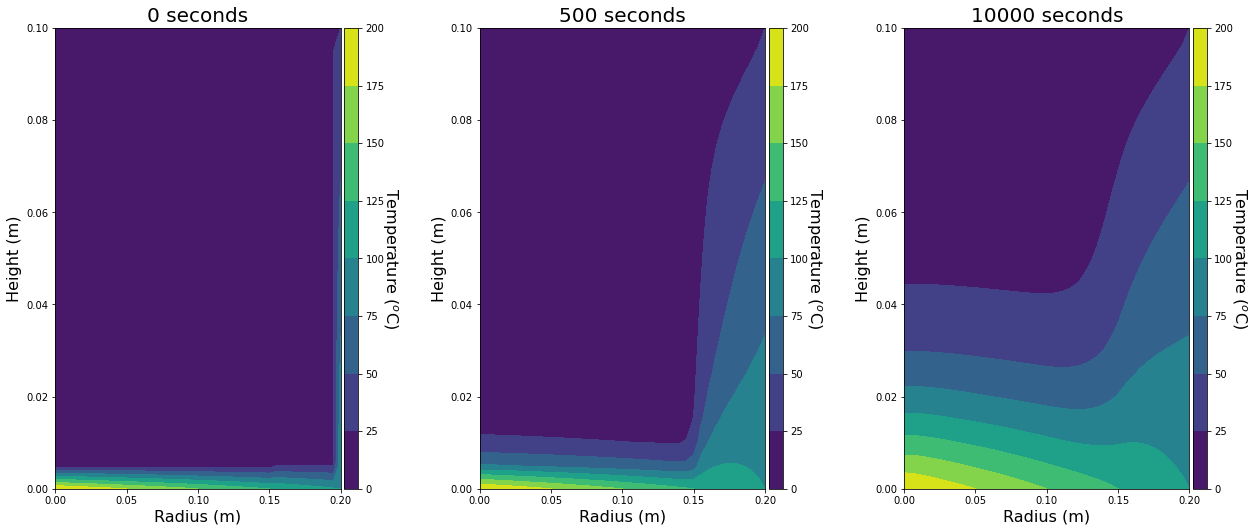

In [18]:
dt = base_time_increment
dr = base_radial_increment
dz = base_height_increment

Temperature_with_cake_matrix = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=3, 
    pizza_is_in_oven_bool=False, 
    cake_is_in_oven_bool=True
)

## Average and Minimum temperatures against time

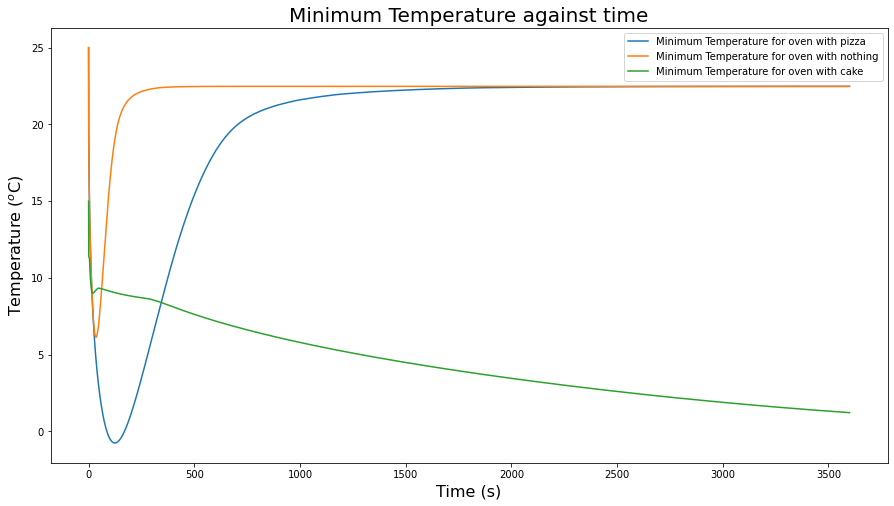

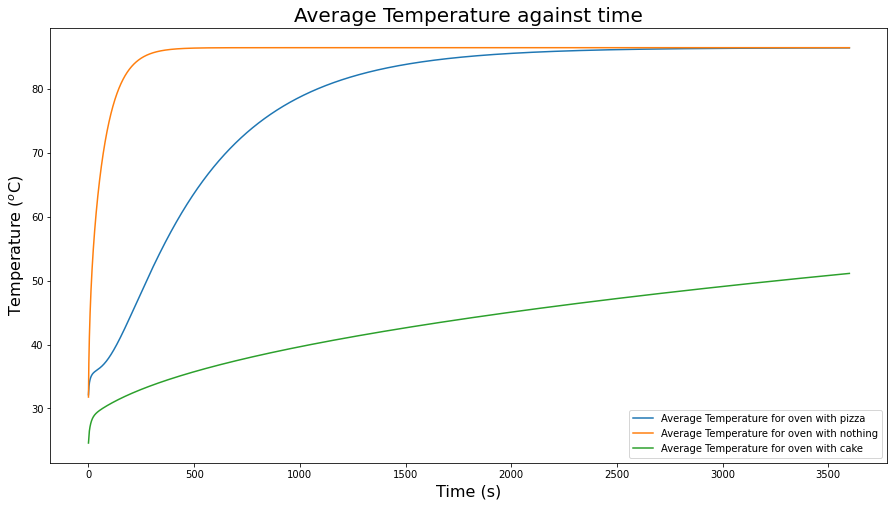

In [19]:
t_array, r_array, z_array = get_dependent_variable_arrays(
    simulation_duration=simulation_duration, 
    time_increment=dt,
    radial_increment=dr,
    height_increment=dz)

Nt, Nr, Nz = get_number_of_increments_in_dependent_variable_arrays(t_array, r_array, z_array)

plot_temperature_against_time(
    option='Minimum', # plots minimum temperature against time
    Temperature_matrices=[Temperature_with_pizza_matrix, Temperature_with_nothing_in_oven_matrix, Temperature_with_cake_matrix],
    time_array=t_array,
    number_time_increments=Nt)

plot_temperature_against_time(
    option='Average', # plots average temperature against time
    Temperature_matrices=[Temperature_with_pizza_matrix, Temperature_with_nothing_in_oven_matrix, Temperature_with_cake_matrix],
    time_array=t_array,
    number_time_increments=Nt)

# Grid Analysis

## Courser grids
A more course grid reduces the number of required operations and does not result in issues of convergence. It means the resolution of the contour plots is reduced.

They are to show that the model's output is independent of grid size.

### 

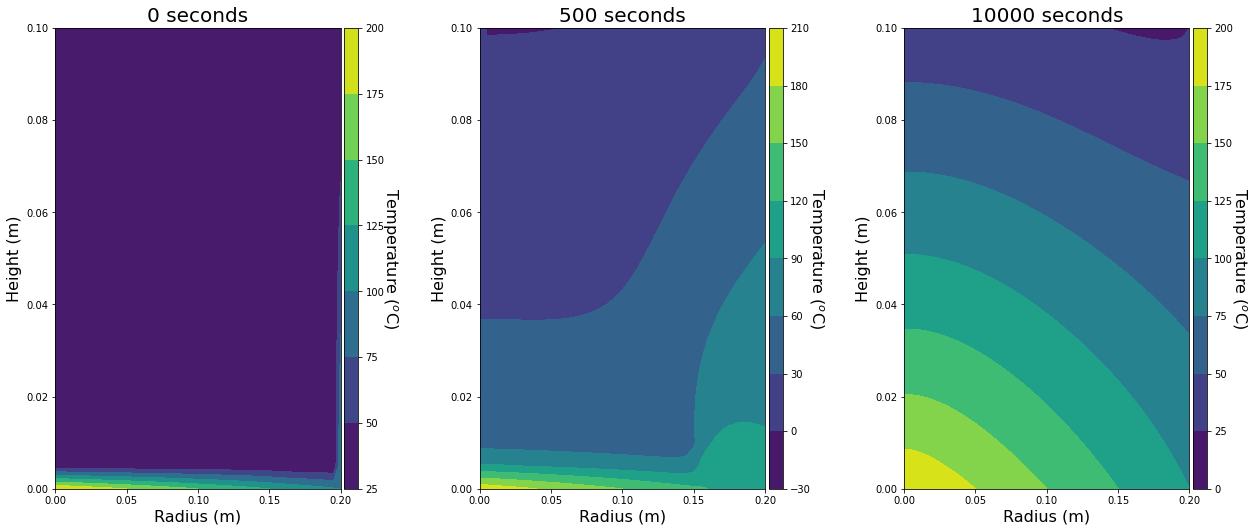

In [20]:
# Original grid size for comparison

t_array, r_array, z_array = get_dependent_variable_arrays(simulation_duration=simulation_duration, time_increment=dt, 
    radial_increment=dr, height_increment=dz)
plot_contours(Temperature_matrix=Temperature_with_pizza_matrix, number_of_plots=3, radius_array=r_array, height_array=z_array)

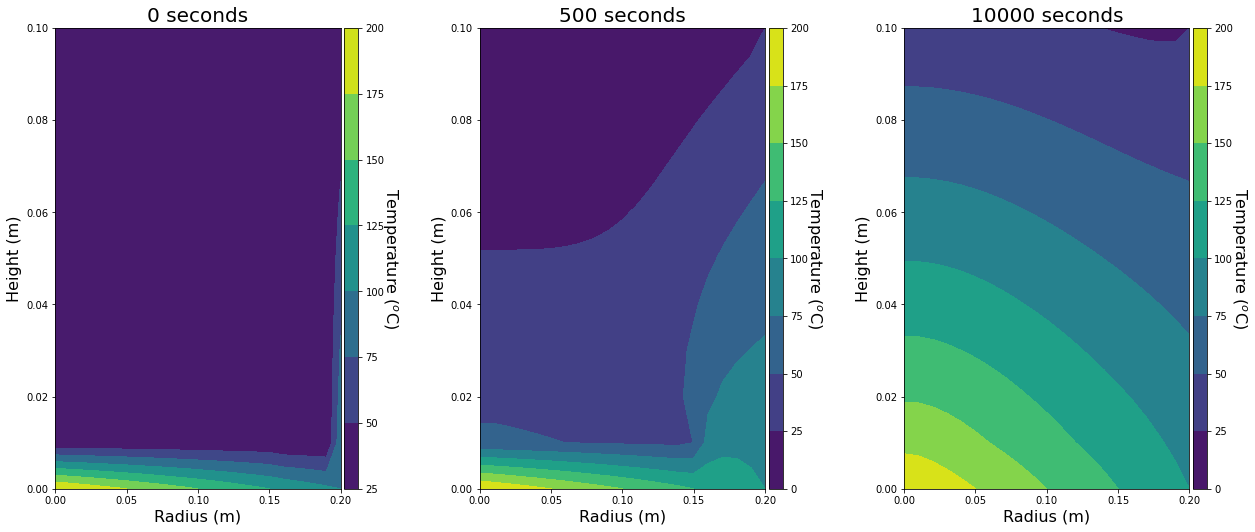

In [21]:
# 2 times courser grids (spatial increments are 2 times larger)

dt = base_time_increment
dr = base_radial_increment * 2
dz = base_height_increment * 2

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=3, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)

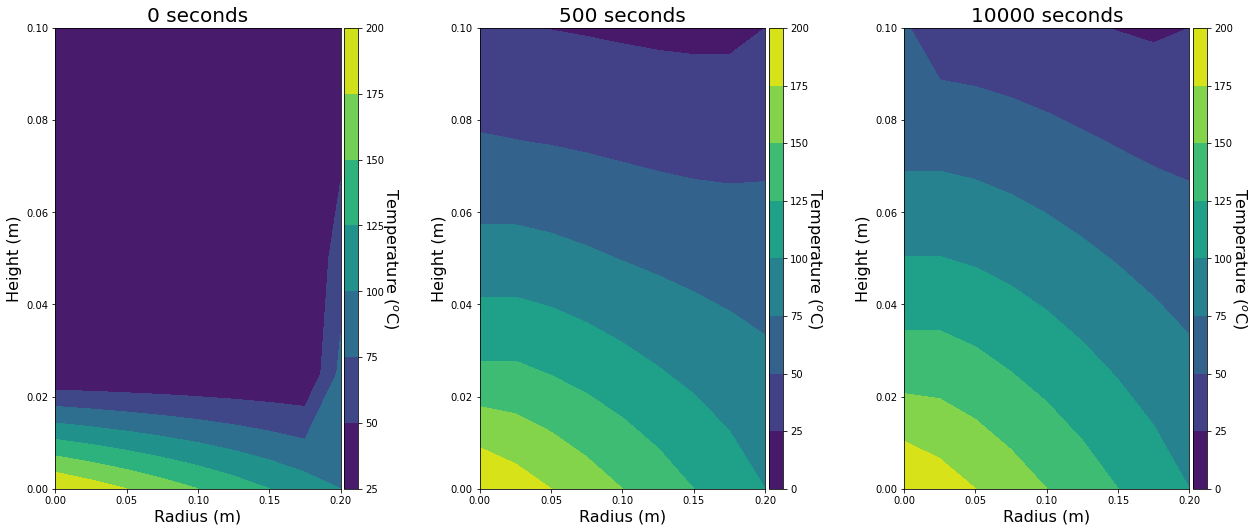

In [22]:
# 5 times courser grids (spatial increments are 2 times larger)

dt = base_time_increment
dr = base_radial_increment * 5
dz = base_height_increment * 5

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=3, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)

## Finer grids
A more fine grid increases the number of required operations and can result in issues related to convergence.

C:\Users\Charlie\AppData\Local\Temp\ipykernel_22212\761554440.py:23: RuntimeWarning: overflow encountered in double_scalars
  Temperature_matrix[p, i, -1] = ((thermal_conductivity_air * Temperature_matrix[p, i, -2]) / dz - convective_heat_transfer_coefficient *
C:\Users\Charlie\AppData\Local\Temp\ipykernel_22212\761554440.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Temperature_matrix[p, i, j] = Temperature_matrix[p-1, i-1, j] * (Cr2 - Cr1 * 1 / radius_array[i]) + \
C:\Users\Charlie\AppData\Local\Temp\ipykernel_22212\761554440.py:13: RuntimeWarning: overflow encountered in double_scalars
  Temperature_matrix[p, i, j] = Temperature_matrix[p-1, i-1, j] * (Cr2 - Cr1 * 1 / radius_array[i]) + \
C:\Users\Charlie\AppData\Local\Temp\ipykernel_22212\761554440.py:15: RuntimeWarning: overflow encountered in double_scalars
  Temperature_matrix[p-1, i, j] * (1 - 2 * Cr2 - 2 * Cz2) + \
C:\Users\Charlie\AppData\Local\Temp\ipykernel_22212\761554440.py:27: RuntimeWarning: overfl

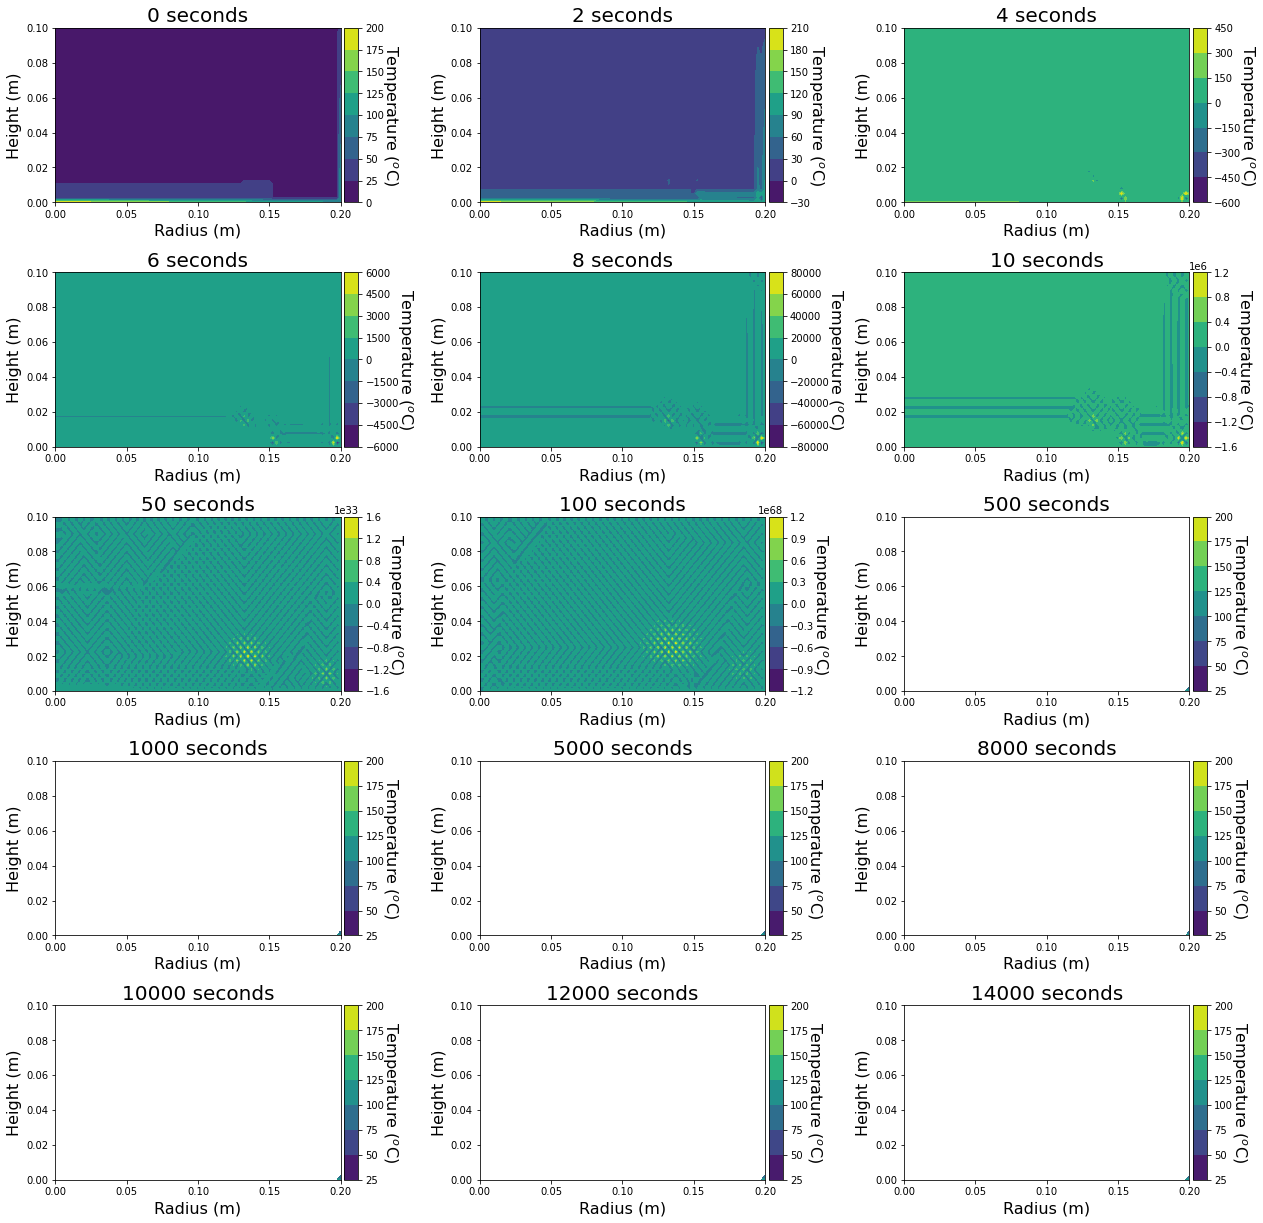

In [23]:
# 2 times finer grids (spatial increments are 2 times smaller)

dt = base_time_increment
dr = base_radial_increment / 2
dz = base_height_increment / 2

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=15, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False
)

The below cell runs a simuluation with a grid size 10 times finer than the original. The cell was run for half an hour, but still had not finished the simulation. 

In [ ]:
# 10 times finer grids (spatial increments are 50 times smaller)

dt = base_time_increment
dr = base_radial_increment / 10
dz = base_height_increment / 10

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=15, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)

In [ ]:
# 50 times finer grids (spatial increments are 50 times smaller)

dt = base_time_increment
dr = base_radial_increment / 50
dz = base_height_increment / 50

Temperature_with_pizza_matrix_2_times_coarser_grid = perform_simulation_and_plot_contours(
    time_increment=dt, 
    radial_increment=dr, 
    height_increment=dz, 
    number_of_plots=15, 
    pizza_is_in_oven_bool=True, 
    cake_is_in_oven_bool=False    
)